## Introduction

This notebook illustrates how we can compare documents using cosine similarity. It does so in two ways. 

The first example builds simple binary vectors for every document, with 1 if a word is present and 0 otherwise. We then calcuate cosine similarty using these vectors. We don't do this for all parts of speech, at the moment the code looks for nouns, verbs and adjectives.

The second example calculates cosine similarity using Spacy's inbuilt function, which uses Word2Vec to compare similarity. This means that words with similar **context** (trained empirically) are more similar.

**The program reads in data either from our geograph test data or a directory containing files to build a dataset. We can then extract a sample for comparisons**
1) [Geograph](https://geograph.org.uk) 
This site invites users to take pictures in the UK and add descriptions. It has almost 7 million pictures, and the data are licenced using a CC By-SA licence, making them available for research as long as we keep the names of the users, and allow others to have access to any data we might create.

**The first block of our code initialises libraries and reads in data. We only need to do this once.**

In [1]:
import OSGridConverter #To convert from =SGB36 to WGS84
import pandas as pd #To use pandas for elegant data handling
import spacy #Our NLP tools
import matplotlib.pyplot as plt #To plot results
from matplotlib.figure import Figure #To plot results
from matplotlib.ticker import MaxNLocator #To plot results
import numpy as np #To do some numerical things
import scipy
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
import math # To calculate square root

#import os #We import os to stop a weird kernel crash...
#os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

#Load a language model to do NLP
nlp = spacy.load("en_core_web_md") # We can't use the sm model here because it doesn't calculate token2vec

In [2]:
#Read in the geograph data
geograph = pd.read_csv('./data/geograph_mini_corpus.csv')
print(len(geograph))
#Filter for odd values
#geograph = geograph.drop(geograph[geograph.text.eq('')].index)
geograph = geograph.drop(geograph[np.isnan(geograph.lon)].index)
geograph = geograph.drop(geograph[np.isnan(geograph.lat)].index)
print(len(geograph))
geograph.head()



138639
138362


,id,author,title,text,lon,lat
0,2749148,M J Richardson,Great Blasket Island - 1960,Looking northeast along the northwestern side ...,-10.534101,52.097794
1,635105,Bob Shires,White Beach Great Blasket,The only beach on Great Blasket as seen from t...,-10.514872,52.107609
2,635109,Bob Shires,Remaining homes on Great Blasket,The remaining few habited homes of the abandon...,-10.511764,52.104260
3,259349,Nigel Cox,Coumeenoole Bay,Viewed looking back from the Dunmore Head head...,-10.463579,52.109322
4,16917,Pam Brophy,Clogher Beach,The exact gpr for this beach is Q3153003375. T...,-10.463338,52.157867


This block shows how Word2Vec works in Spacy. Words similarities are calculated using context trained on empirical data. You can read more about Word2Vec here: https://code.google.com/archive/p/word2vec/

In [3]:
#First we demonstrate how similarity  works for individual tokens
#Notice how words that mean the opposite are similar (hates/ likes) and how context matters (ands)
doc = nlp("Ross likes hills and mountains. He hates pizza, pasta and fish.")

print('',end='\t')
for t in doc:
    if not t.is_punct:
        print(t.text[0:4], end='\t')
print()

for t1 in doc:
    if t1.is_punct:
        continue
    print(t1.text[0:4], end='\t')
    for t2 in doc:
        if t2.is_punct:
            continue
        sim = round(t1.similarity(t2),2)
        if sim > 0.3: #We use this line to out using a threshold
            print(sim, end='\t')
        else:
            print('', end='\t')
    print()




	Ross	like	hill	and	moun	He	hate	pizz	past	and	fish	
Ross	1.0											
like		1.0				0.37	0.46					
hill			1.0		0.79							
and				1.0	0.3	0.5				1.0	0.3	
moun			0.79	0.3	1.0					0.3		
He		0.37		0.5		1.0	0.48			0.5		
hate		0.46				0.48	1.0					
pizz								1.0	0.74		0.38	
past								0.74	1.0		0.43	
and				1.0	0.3	0.5				1.0	0.3	
fish				0.3				0.38	0.43	0.3	1.0	


Here we **draw a random sample of documents** from our corpus and analyse those data. We can rerun this block to build a new sample. The size of this sample can also be changed.

In [4]:
#Now I am going to load a random sample of m documents and run the NER pipeline
m = 100
sample = geograph.sample(n = m)
docs = list(nlp.pipe(sample.text, batch_size=100))

This code block only makes sense if documents have locations. It calculates all the pairwise distances, to allow us to test the hypothesis that document similarity is related to distance.

In [5]:
# We use this block to calculate the distances between all the documents
# We are interested in finding out later if there is a relationship between distance and cosine similarity
dists = [] 
a = sample.columns.get_loc('lon')
b = sample.columns.get_loc('lat')

for i in range(m):
    lon1 = sample.iloc[i, a]
    lat1 = sample.iloc[i, b]
    for j in range(m):
        lon2 = sample.iloc[j, a]
        lat2 = sample.iloc[j, b]
    #print(lon1, lat1, lon2, lat2)
        try:
            g1 = OSGridConverter.latlong2grid (lat1, lon1, tag = 'WGS84')
            g2 = OSGridConverter.latlong2grid (lat2, lon2, tag = 'WGS84')
            dist = math.sqrt((g1.N - g2.N)*(g1.N - g2.N) + (g1.E - g2.E)*(g1.E - g2.E))/1000
        except ValueError:
            dist = 1000 #This is an ugly fix - if the coordinates are dodgy, we assume the documents are far apart
        dists.append(dist)

Build a dictionary of terms in all our documents which we then use for building vectors for similarity comparisons.

In [6]:
#Create a list of all tokens we want to keep in our collection
pos = set()
for doc in docs:
    for chunk in doc:        
        for token in doc:
            if token.pos_ == 'NOUN' or token.pos_ == 'ADJ' or token.pos_ == 'VERB': #Here we choose which parts of speech we keep
                pos.add(token.text.lower())

pos = (sorted(list(pos)))
print(pos)

['%', '-', '1960s', 'according', 'apartment', 'appears', 'approved', 'arable', 'arches', 'are', 'area', 'atmosphere', 'backdrop', 'background', 'bank', 'base', 'beech', 'been', 'beginning', 'belonging', 'bench', 'bends', 'bit', 'blocks', 'bottom', 'break', 'bridge', 'building', 'buildings', 'built', 'bus', 'called', 'canal', 'capacity', 'carriageway', 'carries', 'cascades', 'castle', 'cathedral', 'caves', 'cement', 'cemetery', 'centre', 'centred', 'church', 'churchyard', 'cleared', 'clearing', 'cliffs', 'climbs', 'close', 'closed', 'col', 'commercialised', 'compare', 'confluence', 'conservation', 'considerable', 'contrast', 'copse', 'corner', 'cottages', 'course', 'covered', 'covering', 'crop', 'crosses', 'crossing', 'culvert', 'cut', 'dammed', 'debris', 'deciduous', 'degree', 'demolished', 'demolition', 'deposits', 'derelict', 'descending', 'desirable', 'development', 'dinosaur', 'dip', 'direction', 'discernible', 'distance', 'dominates', 'drainage', 'drier', 'drive', 'drop', 'dual', 

In [7]:
#Create an empty data frame to store the term vectors we are going to build
vectors = pd.DataFrame(0, sample.id, pos)

#Build the binary vectors, iterating through each document
i=0
for doc in docs:
    doc = list(map(str, doc))
    for n in pos:
        a = vectors.columns.get_loc(n)
        if n in [x.lower() for x in list(doc)]:
            vectors.iloc[i, a] = 1
    i=i+1

#print(vectors) #This is a term document indcidence matrix as we say earlier in the course

Compare pairwise all documents using their binary term incidence matrices. Similar documents have cosine ~1, documents with no overlap have cosine = 0.

[[1.         0.         0.         ... 0.         0.16666667 0.16666667]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.16666667 0.         0.         ... 0.         1.         0.        ]
 [0.16666667 0.         0.         ... 0.         0.         1.        ]]


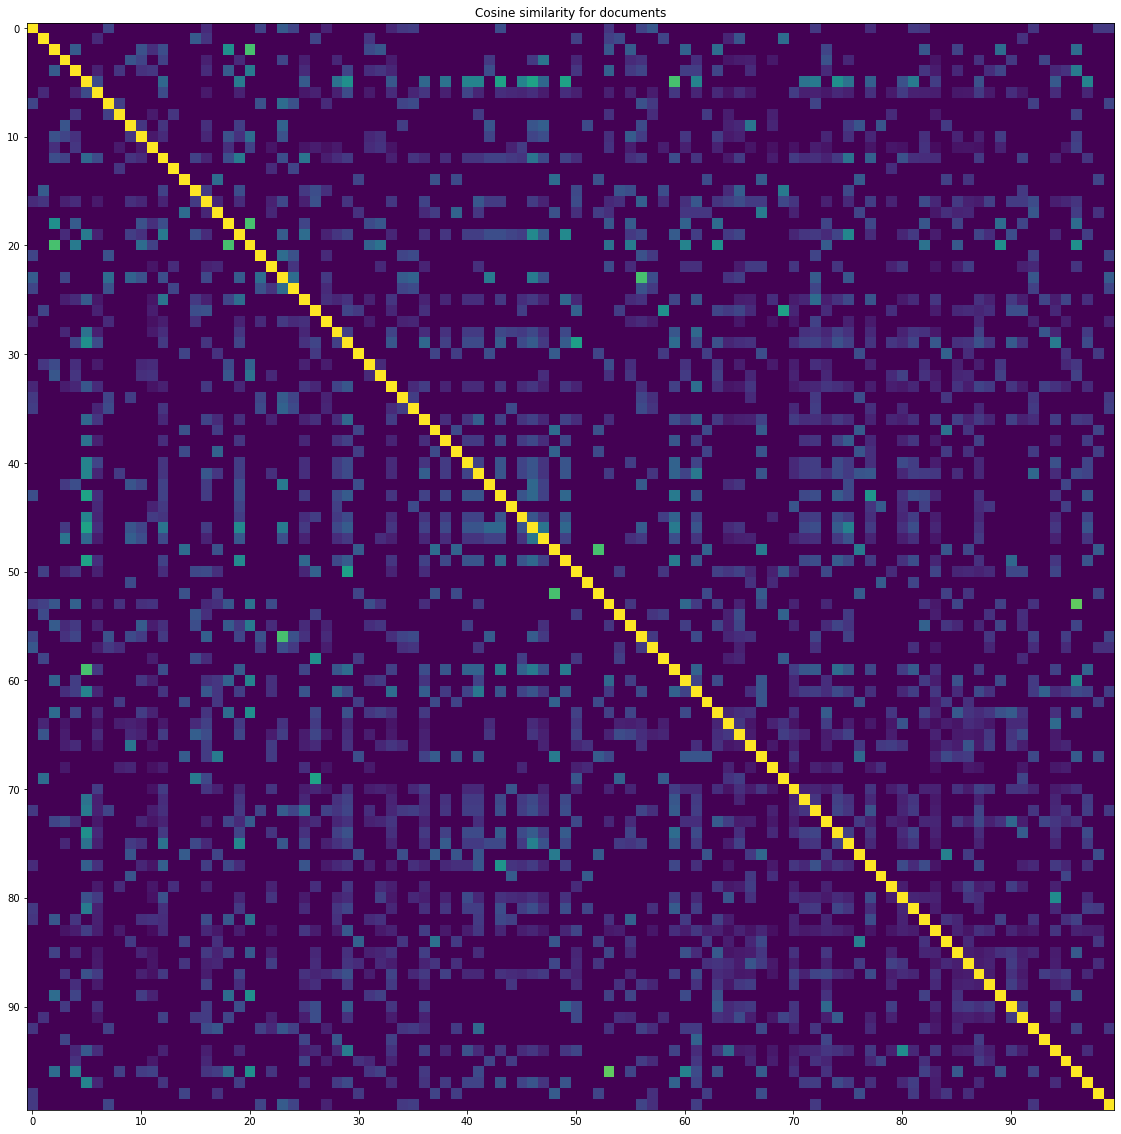

In [8]:
cosine = cosine_similarity(vectors) # We can calculate cosine using these binary vectors

print(cosine)

fig2 = plt.figure(figsize = (20,20)) # create a 5 x 5 figure 
ax = fig2.add_subplot(111)
ax.imshow(cosine, interpolation='none')
ax.set_title('Cosine similarity for documents')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show() #Plot the cosine similarity. Remember, the diagonal is 1 and the matrix is symmetric

In [16]:
#Look at content of potentially interesting documents
a = sample.columns.get_loc('text')

print(sample.iloc[96, a])
print()
print(sample.iloc[54, a])


Cottages on the main road through the village.

The market Square in the centre of this historic town


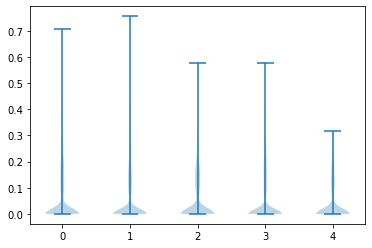

In [10]:
#This block plots violin plots of the cosine similarity as a function of distance
classes = 5 #Change this value to modify the number of classes we plot
m1 = min(dists)
m2 = max(dists)
step = (m2 - m1)/classes+1
boxes = {}

rows = len(cosine)
cols = len(cosine[0])
for i in range(rows):
    for j in range(cols):
        k = (cols * i) + j
        if i is not j:
            dist = dists[k]
            cos = cosine[i][j]
            box = int(dist/step)            
            if box in boxes.keys():
                boxes[box].append(cos)
            else:
                boxes[box] = [cos]
   
labels, data = sorted(boxes.keys()), boxes.values()

plt.violinplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

Compare documents using word2vec. We can filter the documents so only some terms are used. Important to remember that this is still a bag of words approach.

<ipython-input-11-c126276ca1e3>:11: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  value = d1.similarity(d2)


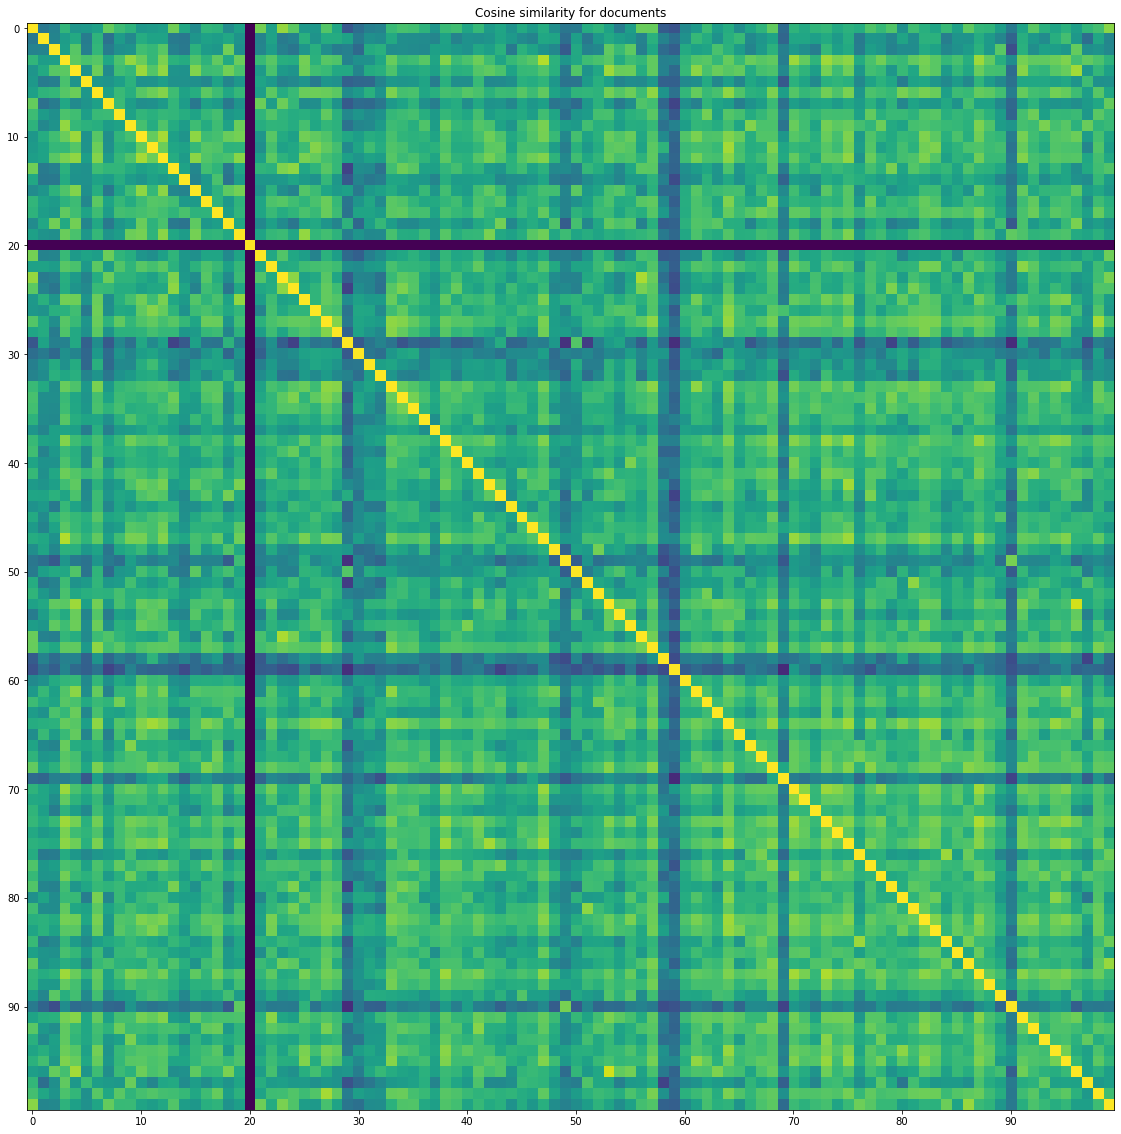

In [11]:
#Calculate similarity between documents using cosine similarity in Spacy (based on Word2Vec)
cosine = [] 
#In this code we don't use all the words; we filter out entities, stop words and punctuation
for doc1 in docs:
    s1 = " ".join([ent.text for ent in doc1 if not ent.ent_type_ if not ent.is_stop if not ent.is_punct]) 
    d1 = nlp(s1)    
    sim = []
    for doc2 in docs:
        s2 = " ".join([ent.text for ent in doc2 if not ent.ent_type_ if not ent.is_stop if not ent.is_punct])
        d2 = nlp(s2)
        value = d1.similarity(d2)
        #value = doc1.similarity(doc2)
        sim.append(value)
    cosine.append(sim)
    
#Plot the similarity matrix again
fig2 = plt.figure(figsize = (20,20)) # create a 5 x 5 figure 
ax = fig2.add_subplot(111)
ax.imshow(cosine, interpolation='none')
ax.set_title('Cosine similarity for documents')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

In [12]:
#Look at content of potentially interesting documents
a = sample.columns.get_loc('text')

print(sample.iloc[16, a])
print()
print(sample.iloc[27, a])

print(sample.iloc[3])

Another view of [[2218576]] looking back along the footpath to Town Littleworth Road. The building is a poultry shed belonging to Springles Farm.

With the reservoir operating at 88% capacity some of the trees are lying below the water line at the moment making interesting reflective patterns. Through the foliage the north bank can just be glimpsed.
id                                                  1593926
author                                          Nigel Brown
title                              Stob Coir' an Albannaich
text      Looking over the steep-sided col which separat...
lon                                               -4.988009
lat                                               56.548855
Name: 13666, dtype: object


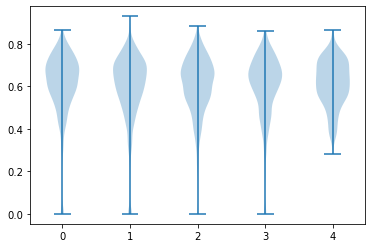

In [13]:
#This block plots violin plots of the cosine similarity as a function of distance
classes = 5 #Change this value to modify the number of classes we plot
m1 = min(dists)
m2 = max(dists)
step = (m2 - m1)/classes+1
boxes = {}

rows = len(cosine)
cols = len(cosine[0])
for i in range(rows):
    for j in range(cols):
        k = (cols * i) + j
        if i is not j:
            dist = dists[k]
            cos = cosine[i][j]
            box = int(dist/step)            
            if box in boxes.keys():
                boxes[box].append(cos)
            else:
                boxes[box] = [cos]
   
labels, data = sorted(boxes.keys()), boxes.values()

plt.violinplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

In [14]:
#output all dependencies so that we can reproduce the notebook (we only need this to set things up for Binder)
#%load_ext watermark
#%watermark --iversions